In [1]:
import time
from typing import Iterable

import np as np
import torch
from cgtasknet.tasks.reduce import ReduceTaskCognitive


class EveryTaskSubgroups:
    device = torch.device("cpu")

    def __init__(
            self, model: torch.nn.Module, tasks: Iterable[ReduceTaskCognitive]
    ) -> None:
        self._tasks = tasks
        self._model = model
        self._subgroups_finder = None

    def run(self, number_of_trials: int, dt: float = 1e-3):
        self._subgroups_finder = []
        number_of_trials = int(number_of_trials)
        dt = float(dt)
        print("*" * 20, "Start")
        for current_task in self._tasks:
            t0 = time.perf_counter()
            self._subgroups_finder.append(0)
            for i in range(number_of_trials):
                inputs, t_outputs, s, out = self._run_trial(current_task)
                self._subgroups_finder[-1] += torch.mean(s, dim=0)
            self._subgroups_finder[-1] /= number_of_trials
            print(
                f"Complete task: {current_task.task_number}, time: {time.perf_counter() - t0}s"
            )

    def _run_trial(self, task: ReduceTaskCognitive):
        inputs, t_outputs = task.dataset()
        inputs = torch.from_numpy(inputs).type(torch.float).to(self.device)
        t_outputs = torch.from_numpy(t_outputs).type(torch.float).to(self.device)
        out, _, s = self._model(inputs)
        s = torch.stack(s).detach()
        s = s.reshape((s.shape[0], s.shape[2]))
        return inputs, t_outputs, s, out

    def get_frequencies(self):

        return self._subgroups_finder

In [2]:
import torch
from cgtasknet.tasks.reduce import (
    CtxDMTaskParameters,
    DMTaskParameters,
    DMTaskRandomModParameters,
    MultyReduceTasks,
    RomoTaskParameters,
    RomoTaskRandomModParameters,
    GoTaskParameters,
    GoTaskRandomModParameters,
    GoRtTaskParameters,
    GoRtTaskRandomModParameters,
    GoDlTaskParameters,
    GoDlTaskRandomModParameters

)
import matplotlib.pyplot as plt


In [3]:
go_task_list_values = np.linspace(0, 1, 8)

batch_size = 1
number_of_tasks = 1
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.8,
        #positive_shift_delay_time=1.5,
        trial_time=0.4,
        #positive_shift_trial_time=0.4,
        answer_time=.25
    ),
)
dm_parameters = DMTaskRandomModParameters(
    #dm=DMTaskParameters(trial_time=0.3, positive_shift_trial_time=1.5, answer_time=.25)
    dm=DMTaskParameters(trial_time=0.8,  answer_time=.25)
)
ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm)
go_parameters = GoTaskRandomModParameters(
    go=GoTaskParameters(
        trial_time=0.3,
        positive_shift_trial_time=1.5,
        value=go_task_list_values,
        answer_time=.25
    )
)
gort_parameters = GoRtTaskRandomModParameters(
    go_rt=GoRtTaskParameters(
        trial_time=0.3,
        positive_shift_trial_time=1.5,
        answer_time=1.5,
        value=go_task_list_values,
    )
)
godl_parameters = GoDlTaskRandomModParameters(
    go_dl=GoDlTaskParameters(
        go=GoTaskParameters(trial_time=0.2, positive_shift_trial_time=0.4, answer_time=.25, value=go_task_list_values),
        delay=0.2,
        positive_shift_delay_time=1.5,

    )
)
sigma = 0.5
tasks = ["RomoTask1", "RomoTask2", "DMTask1", "DMTask2", "CtxDMTask1", "CtxDMTask2", "GoTask1", "GoTask2", "GoRtTask1",
         "GoRtTask2", "GoDlTask1", "GoDlTask2"]
task_dict = {
    tasks[0]: romo_parameters,
    tasks[1]: romo_parameters,
    tasks[2]: dm_parameters,
    tasks[3]: dm_parameters,
    tasks[4]: ctx_parameters,
    tasks[5]: ctx_parameters,
    tasks[6]: go_parameters,
    tasks[7]: go_parameters,
    tasks[8]: gort_parameters,
    tasks[9]: gort_parameters,
    tasks[10]: godl_parameters,
    tasks[11]: godl_parameters,
}

tasks_sequence = [MultyReduceTasks(
    tasks=task_dict,
    batch_size=batch_size,
    delay_between=0,
    enable_fixation_delay=True,
    task_number=i,
) for i in range(len(tasks))]



In [4]:
from cgtasknet.net import SNNlifadex
from norse.torch import LIFAdExParameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
feature_size, output_size = tasks_sequence[0].feature_and_act_size
hidden_size = 256

neuron_parameters = LIFAdExParameters(
    v_th=torch.as_tensor(0.45),
    tau_ada_inv=1 / 2,
    alpha=100,
    method="super",
    # rho_reset = torch.as_tensor(5)
)
model = SNNlifadex(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=20,
    save_states=True,
    return_spiking=True,
).to(device)
model.load_state_dict(
    torch.load(
        r"A:\src\multy_task\models\low_freq\mean_fr_filter_less_v_th_0_45\weights\weights_100_N_256_without_square_2999_"
    )
)

<All keys matched successfully>

In [13]:
from norse.torch import LIFAdExState
inputs, toutputs = tasks_sequence[sorted(tasks).index('RomoTask1')].dataset(1)
inputs = np.concatenate((inputs, tasks_sequence[0].dataset(1)[0]))
inputs_2, toutputs_2 = tasks_sequence[0].dataset(2)
print(len(inputs))
#inputs = np.concatenate((inputs, inputs_2), axis=0)
print(len(inputs))
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
inputs_2 = torch.from_numpy(inputs_2).type(torch.float).to(device)
init_state = LIFAdExState(
            torch.zeros(batch_size, hidden_size).to(device),
            torch.rand(batch_size, hidden_size).to(device) * 1,
            torch.zeros(batch_size, hidden_size).to(device),
            torch.rand(batch_size, hidden_size).to(device) * 0.,
        )
results1 = model(inputs, init_state)
results2 = model(inputs_2, init_state)



<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ValueError: could not broadcast input array from shape (1050,1,15) into shape (1050,1)

In [6]:
outputs, states, s_list = results1
outputs2, states2, s_list_2 = results2
outputs = outputs.detach().cpu()
outputs2 = outputs2.detach().cpu()
s = torch.concat(s_list).detach().cpu()
s2 = torch.concat(s_list_2).detach().cpu()
s = torch.concat((s, s2))

In [7]:
import seaborn as sns
import pandas as pd



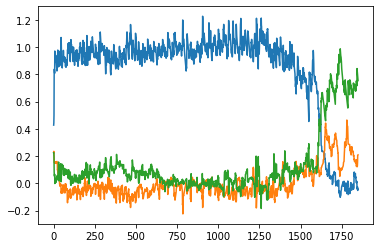

In [8]:
plt.plot(outputs[:, 0, :])

In [9]:
outputs = np.concatenate((outputs, outputs2), axis=0)
data_outputs = pd.DataFrame({

    'x': [*range(len(outputs))] * 3,
    'data': outputs.flatten('F'),
    'type': ['$y_{fix}$'] * len(outputs) + ['$y_1$'] * len(outputs) + ['$y_2$'] * len(outputs),
})

<AxesSubplot:xlabel='x', ylabel='data'>

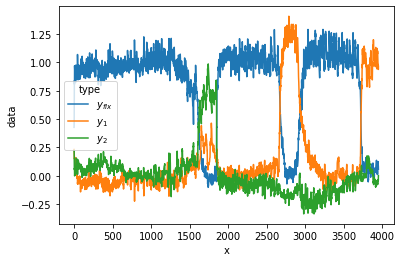

In [10]:
sns.lineplot(data=data_outputs, x='x', y='data', hue='type')

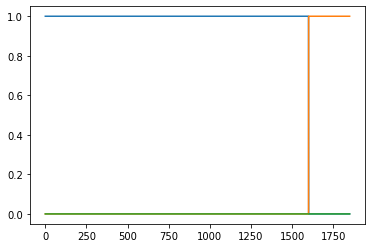

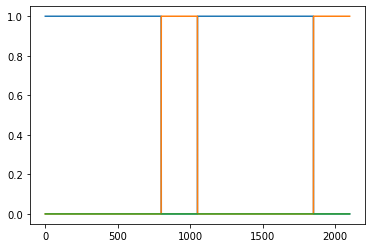

In [11]:
plt.plot(toutputs[:, 0, :])
plt.show()
plt.close()
plt.plot(toutputs_2[:, 0, :])

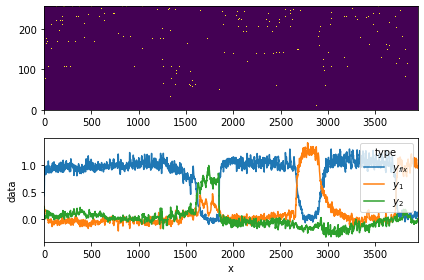

In [12]:
indexes_for_sort = [  35,  46, 205,  27,  39, 190, 198, 134,  44,  65, 124, 177, 162, 175,
          0,  34, 114, 118, 229, 224, 100,  86,   6, 161, 248, 223, 180, 249,
        130,  96,  80, 218, 216, 178, 246,  37,  83, 209, 185, 170,  43,   2,
        227, 228,  31, 183, 237, 189,  75, 188, 159, 108, 150,  91, 117,  85,
        137,  77, 142,  60,  69, 187,  25, 156,  54, 112, 123, 133, 128,  28,
         19,  81, 132,  78, 201, 233, 144, 105, 172, 242,  70,  99, 169, 155,
        158,  24,  74, 204, 113,  11,  51, 145,  13, 119, 154, 247, 234, 126,
        115, 152, 200, 168,  20, 109,  73, 191, 239, 197,  49,  47, 195,  68,
        235, 121, 230,  30,  21,  92, 222,  94, 199,  32, 192,  84, 203, 236,
         62, 252,  72,  82, 208, 157, 221, 226,  87,  97,   1, 110,  79, 253,
         38,   3, 238, 240, 219,  14, 116,  23,   8, 143, 211,  18,  89, 182,
        207, 241, 225, 220, 141, 210, 103,  98, 135, 120, 215,  15, 166,  22,
        106,  48, 173,  45,   9, 243, 153, 174, 136,   7, 129, 244,  29, 254,
         26, 194,  95, 102,  17,  88, 171,  10, 101, 111,  66, 212,  53, 202,
        196, 127,  71,  41, 245, 148, 176,  58, 186, 147, 250, 206, 213, 138,
        122, 181,  16,  52, 160,  33, 125, 165, 140, 251, 151, 179, 167, 131,
         36,  63,  40, 163,  55,   5, 146,   4, 232,  57, 149,  76,  64,  93,
         42, 255,  59, 139,  61,  67, 104, 217,  50,  12, 231, 164, 193,  90,
         56, 214, 184, 107]#torch.sort(torch.sum(s[:len(inputs)], dim=0)).indices
s_new = torch.zeros_like(s)
for i in range(hidden_size):
    s_new[:, i] = s[:, indexes_for_sort[i]]
plt.figure()
ax = plt.subplot(211)
#sns.heatmap(s.T, ax=ax, cbar='False', vmax=0.1, cmap='Greys_r')
ax.imshow(s_new.T, aspect='auto', origin='lower', interpolation='nearest')
#sns.lineplot([len(inputs)] * 2, [0, hidden_size], color='r', ax=ax, linewidth=100)
ax = plt.subplot(212)
line = sns.lineplot(data=data_outputs, x='x', y='data', hue='type', ax=ax)
line.set(xlim=(0, len(outputs)))
plt.tight_layout()